## KNN Regression
In addition to being a classifier, KNN is also a reasonable algorithm for regression. In our previous models, each of the  𝑘 oberservations voted for a category. As a regression they vote instead for a value. Then instead of taking the most popular response, the algorithm averages all of the votes. If you have weights you perform a weighted average.


We'll be revisiting the music data. Instead of trying to classify songs as rock or jazz, lets take the same data with an additional column: beats per minute, or BPM. Can we train our model to predict BPM?

First, let's try to predict just in terms of loudness.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
%matplotlib inline

music = pd.DataFrame()
music['duration'] = [184, 134, 243, 186, 122, 197, 294, 382, 102, 264, 
                     205, 110, 307, 110, 397, 153, 190, 192, 210, 403,
                     164, 198, 204, 253, 234, 190, 182, 401, 376, 102]
music['loudness'] = [18, 34, 43, 36, 22, 9, 29, 22, 10, 24, 
                     20, 10, 17, 51, 7, 13, 19, 12, 21, 22,
                     16, 18, 4, 23, 34, 19, 14, 11, 37, 42]
music['bpm'] = [ 105, 90, 78, 75, 120, 110, 80, 100, 105, 60,
                  70, 105, 95, 70, 90, 105, 70, 75, 102, 100,
                  100, 95, 90, 80, 90, 80, 100, 105, 70, 65]

In [2]:
# Music df 

music.head()

,duration,loudness,bpm
0,184,18,105
1,134,34,90
2,243,43,78
3,186,36,75
4,122,22,120


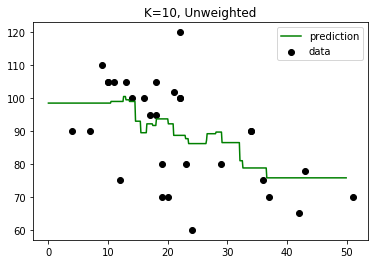

In [3]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

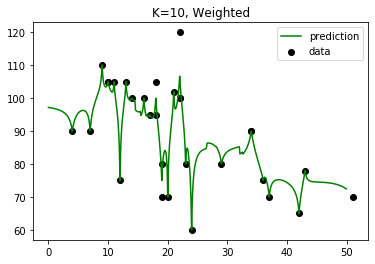

In [4]:
# Run the same model, this time with weights.
knn_w = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
X = pd.DataFrame(music.loudness)
Y = music.bpm
knn_w.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

Y_ = knn_w.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Weighted')
plt.show()

Notice how it seems like the weighted model grossly overfits to points. It is interesting that it oscillates around the datapoints. This is because the decay in weight happens so quickly.

## Validating KNN

Now validating KNN, whether a regression or a classifier, is pretty much exactly the same as evaluating other classifiers or regression. Cross validation is still tremendously valuable. You can do holdouts. You even still get an $R^2$ value for the regression.


In [5]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(knn, X, Y, cv=5)
print("Unweighted Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score_w = cross_val_score(knn_w, X, Y, cv=5)
print("Weighted Accuracy: %0.2f (+/- %0.2f)" % (score_w.mean(), score_w.std() * 2))

Unweighted Accuracy: -0.18 (+/- 0.66)
Weighted Accuracy: 0.11 (+/- 0.94)


From the scores, this model has a -18% of unweighted accuracy and 11% of weighted acurracy. Since the distance between data points is important to the KNN algorithm,  we will normalize or standardize our data.  

## Tuning KNN

All __normalization__ means is scaling a dataset so that its minimum is 0 and its maximum 1. To achieve this we transform each data point x to 

$$ x = (x - x_min)/(x_max - x_min) $$

__Stardardization__ is slightly different; it's job is to center the data around 0 and to scale with respect to the standard deviation:

$$x=x−μ/σ $$

Let's start with scikit-learn's scale function, which standarizes all features in the array. 

In [6]:
X = pd.DataFrame(music.loudness)
y = music.bpm

In [7]:
from sklearn.preprocessing import scale
Xs = scale(X)
from sklearn.model_selection import train_test_split
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2, random_state=42)
knn_model_2 = knn.fit(Xs_train, y_train)
print('k-NN score for test set: %f' % knn_model_2.score(Xs_test, y_test))
print('k-NN score for training set: %f' % knn_model_2.score(Xs_train, y_train))
y_true, y_pred = y_test, knn_model_2.predict(Xs_test)


k-NN score for test set: -0.001697
k-NN score for training set: 0.267076


After scaling the predictor variables, there was a slight increase of accuracy in the training set. 

Let's try normalizing the data with calculating __z-scores__ which is how far each observation is from the mean expressed in number of standard deviation.  We will use them as the basis for measuring distance works for continuous data and puts everything in terms of how far from the mean (or "abnormal") it is.

In [13]:
import scipy.stats
# Our input data frame will be the z-scores this time instead of raw data.
X_1 = pd.DataFrame({
    'loudness': stats.zscore(music.loudness),
    'duration': stats.zscore(music.duration)
})

Y_1 = scipy.stats.zscore(music['bpm'])

# Convert scalar array to 2D array
T_1 = np.arange(-3, 3, 0.2).reshape(-1,2)

# Fit our model.
knn_norm = KNeighborsRegressor(n_neighbors=7).fit(X_1, Y_1)

Y_1pred = knn_norm.predict(T_1)

score_1 = cross_val_score(knn_norm, X_1, Y_1, cv=5)
print(score_1)
print('Normalized Accuracy: %0.2f (+/- %0.2f)' % (score_1.mean(), score_1.std()))

[-0.09714039  0.24172657 -0.29046931 -2.05188665  0.07248038]
Normalized Accuracy: -0.43 (+/- 0.83)


None of these models look good. 